In [1]:
!pip install xgboost


In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBRegressor
import yfinance as yf
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [6]:
def load_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)
    return data['Close']

In [8]:
# Загрузка данных о ценах Deere & Company (DE) с Yahoo Finance
de_data = yf.download('DE', start='2020-01-01', end='2024-12-31')

[*********************100%***********************]  1 of 1 completed


In [9]:
data_filtered = de_data.loc['2021-01-01':'2024-12-31']
print(data_filtered)

Price            Close        High         Low        Open   Volume
Ticker              DE          DE          DE          DE       DE
Date                                                               
2021-01-04  255.138382  260.962966  251.525407  259.113582  2800000
2021-01-05  261.468262  261.925851  254.957307  255.147947  1829200
2021-01-06  276.797150  279.161318  261.820978  262.154636  2778300
2021-01-07  285.729462  286.520679  279.780916  280.038322  2227300
2021-01-08  280.181335  286.444455  276.825767  283.651294  1781000
...                ...         ...         ...         ...      ...
2024-12-17  443.589996  444.940002  435.000000  436.570007  1357100
2024-12-18  426.000000  445.309998  424.510010  443.200012  1423600
2024-12-19  426.630005  431.059998  421.970001  428.070007  1757200
2024-12-20  432.489990  436.500000  425.739990  426.010010  2446400
2024-12-23  431.190002  432.609985  427.000000  432.630005   478644

[1000 rows x 5 columns]


In [18]:
def create_features(data, look_back=60):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])  # Признаки: предыдущие 60 значений
        y.append(data[i + look_back, 0])      # Цель: следующее значение
    return np.array(X), np.array(y)

In [20]:
scaler = MinMaxScaler()
data_filtered_scaled = scaler.fit_transform(data_filtered.values.reshape(-1, 1))
print(data_filtered_scaled.shape)

(5000, 1)


In [22]:
X, y = create_features(data_filtered_scaled)

# Разделение данных на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Вывод формы тренировочного и тестового наборов для проверки
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3952, 60) (988, 60) (3952,) (988,)


In [24]:
y_direction = (y_train > np.roll(y_train, 1))[1:].astype(int)

# Исключение первого элемента из X_train, чтобы размеры X_train_lr и y_direction совпадали.
X_train_lr = X_train[1:]

# Создание классификатора логистической регрессии с фиксированным random_state для воспроизводимости.
lr_classifier = LogisticRegression(random_state=42)

# Определение параметров для подбора гиперпараметров логистической регрессии:
# - tol: допустимая ошибка (точность).
# - solver: различные алгоритмы для оптимизации логистической регрессии.
lr_params = {
    "tol": [0.00001, 0.0001, 0.001],
    "solver": ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}

# Создание объекта GridSearchCV для поиска наилучших гиперпараметров:
# - lr_classifier: модель логистической регрессии.
# - lr_params: словарь параметров для перебора.
# - cv=5: кросс-валидация с 5 фолдами.
# - n_jobs=-1: использование всех доступных процессоров для ускорения вычислений.
# - verbose=3: вывод информации о процессе выполнения.
lr_grid = GridSearchCV(lr_classifier, lr_params, cv=5, n_jobs=-1, verbose=3)

# Обучение GridSearchCV на данных X_train_lr и y_direction.
lr_grid.fit(X_train_lr, y_direction)

# Сохранение лучших параметров, найденных GridSearchCV, в переменную.
best_lr_params = lr_grid.best_params_

# Вывод лучших параметров модели логистической регрессии
print("Лучшие параметры логистической регрессии:", best_lr_params)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Лучшие параметры логистической регрессии: {'solver': 'lbfgs', 'tol': 1e-05}


In [26]:
# Обучение модели логистической регрессии с использованием лучших гиперпараметров, найденных с помощью GridSearchCV
lr_model = LogisticRegression(**best_lr_params, random_state=42)

# Обучение модели на тренировочных данных
lr_model.fit(X_train_lr, y_direction)

# Вывод информации о модели после обучения
print("Модель логистической регрессии успешно обучена.")

Модель логистической регрессии успешно обучена.


In [28]:
# Создание объекта модели машины опорных векторов (Support Vector Regression, SVR)
svm_classifier = SVR()

# Определение параметров для подбора гиперпараметров SVR:
# - kernel: тип ядра для регрессии (линейное, полиномиальное, радиальная функция и сигмоидальное).
# - degree: степень полинома (используется только для ядра 'poly').
# - gamma: коэффициент ядра ('scale' - автоматическая настройка, 'auto' - на основе количества признаков).
# - tol: допустимая ошибка (точность).
svm_params = {
    "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
    "degree": [1, 3, 5, 7],
    "gamma": ['scale', 'auto'],
    "tol": [0.00001, 0.0001, 0.001]
}

# Создание объекта GridSearchCV для подбора гиперпараметров модели SVR:
# - svm_classifier: модель SVR.
# - svm_params: словарь параметров для перебора.
# - cv=5: кросс-валидация с 5 фолдами.
# - n_jobs=-1: использование всех доступных процессоров для ускорения вычислений.
# - verbose=3: вывод информации о процессе выполнения.
svm_grid = GridSearchCV(svm_classifier, svm_params, cv=5, n_jobs=-1, verbose=3)

# Обучение GridSearchCV на данных X_train и y_train.ravel():
# - .ravel() преобразует массив y_train в одномерный вид, необходимый для SVR.
svm_grid.fit(X_train, y_train.ravel())

# Сохранение лучших параметров, найденных GridSearchCV, в переменную.
best_svm_params = svm_grid.best_params_

# Вывод лучших найденных параметров
print("Лучшие гиперпараметры для модели SVR:", best_svm_params)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Лучшие гиперпараметры для модели SVR: {'degree': 1, 'gamma': 'scale', 'kernel': 'poly', 'tol': 1e-05}


In [30]:
# Создание модели машины опорных векторов (SVR) с лучшими гиперпараметрами
svm_model = SVR(**best_svm_params)

# Обучение модели на тренировочных данных
svm_model.fit(X_train, y_train.ravel())

SVR(degree=1, kernel='poly', tol=1e-05)

In [36]:
rf_classifier = RandomForestRegressor(random_state=42)  # You can specify any other parameters as needed

# Сетку гиперпараметров для 36 кандидатов и 180 fits
rf_params = {
    "n_estimators": [50, 100],
    "criterion": ['squared_error'],
    "max_depth": [10, 50]
}

# Создание объекта GridSearchCV для подбора гиперпараметров
rf_grid = GridSearchCV(rf_classifier, rf_params, cv=3, n_jobs=-1, verbose=3)

# Обучение модели с расширенной сеткой гиперпараметров
rf_grid.fit(X_train, y_train.ravel())

# Сохранение лучших параметров
best_rf_params = rf_grid.best_params_

# Вывод лучших параметров
print("Best Random Forest parameters:", best_rf_params)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Random Forest parameters: {'criterion': 'squared_error', 'max_depth': 10, 'n_estimators': 100}


In [38]:
# Обучение модели случайного леса с лучшими гиперпараметрами
rf_model = RandomForestRegressor(**best_rf_params, random_state=42)
rf_model.fit(X_train, y_train.ravel())

RandomForestRegressor(max_depth=10, random_state=42)

In [42]:
# Создание объекта модели XGBoost для регрессии (XGBRegressor)
xgb_classifier = XGBRegressor()

# Определение параметров для подбора гиперпараметров модели XGBoost:
# - n_estimators: количество деревьев в модели (10, 100, 1000).
# - learning_rate: коэффициент обучения (1, 0.1, 0.01, 0.001).
# - max_depth: максимальная глубина дерева (1, 10, 100).
xgb_params = {
    "n_estimators": [50, 100],  # Сокращение количества деревьев
    "learning_rate": [0.1, 0.01],  # Ограничение до двух значений
    "max_depth": [5, 10]  # Уменьшение глубины деревьев
}


# Создание объекта GridSearchCV для подбора гиперпараметров модели XGBoost:
# - xgb_classifier: модель XGBoost.
# - xgb_params: словарь параметров для перебора.
# - cv=5: кросс-валидация с 5 фолдами.
# - n_jobs=-1: использование всех доступных процессоров для ускорения вычислений.
# - verbose=3: вывод информации о процессе выполнения.
xgb_grid = GridSearchCV(xgb_classifier, xgb_params, cv=5, n_jobs=-1, verbose=3)

# Обучение GridSearchCV на данных X_train и y_train.ravel():
# - .ravel() преобразует массив y_train в одномерный вид, необходимый для XGBoost.
xgb_grid.fit(X_train, y_train.ravel())

# Сохранение лучших параметров, найденных GridSearchCV, в переменную.
best_xgb_params = xgb_grid.best_params_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [48]:
# Создание модели XGBRegressor с лучшими гиперпараметрами
xgb_model = XGBRegressor(**best_xgb_params, random_state=42)

# Печать объекта модели для отображения текущих настроек
print(xgb_model)

# Обучение модели XGBRegressor на тренировочных данных
xgb_model.fit(X_train, y_train.ravel())

# Печать сообщения после успешного обучения
print("XGBRegressor успешно обучен с лучшими гиперпараметрами.")


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)
XGBRegressor успешно обучен с лучшими гиперпараметрами.


In [50]:
def evaluate_model(model, X_test, y_test, model_name):
    """
    Оценка модели с вычислением MAE и RMSE.

    Параметры:
    - model: обученная модель для предсказаний.
    - X_test: тестовые данные (признаки).
    - y_test: тестовые данные (цель).
    - model_name: название модели (например, 'Logistic Regression', 'XGBoost').

    Возвращает:
    - y_pred: предсказания модели.
    """
    if model_name == 'Logistic Regression':
        # Для логистической регрессии прогнозируем направление движения
        y_pred_direction = model.predict(X_test)
        y_pred = np.where(y_pred_direction == 1, y_test + 0.01, y_test - 0.01)
    else:
        # Для других моделей, включая XGBoost, просто предсказываем значения
        y_pred = model.predict(X_test).reshape(-1, 1)

    # Вычисление метрик
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Вывод результатов
    print(f'{model_name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}')
    return y_pred

In [56]:
# Предполагается, что все модели (lr_model, svm_model, rf_model, xgb_model) обучены,
# а также X_test и y_test определены.

# Оценка модели логистической регрессии
lr_pred = evaluate_model(lr_model, X_test, y_test, 'Logistic Regression')

# Оценка модели SVM
svm_pred = evaluate_model(svm_model, X_test, y_test, 'SVM')

# Оценка модели Random Forest
rf_pred = evaluate_model(rf_model, X_test, y_test, 'Random Forest')

# Оценка модели XGBoost
xgb_pred = evaluate_model(xgb_model, X_test, y_test, 'XGBoost')


Logistic Regression - MAE: 0.0100, RMSE: 0.0100
SVM - MAE: 0.0766, RMSE: 0.0810
Random Forest - MAE: 0.0094, RMSE: 0.0334
XGBoost - MAE: 0.0093, RMSE: 0.0326


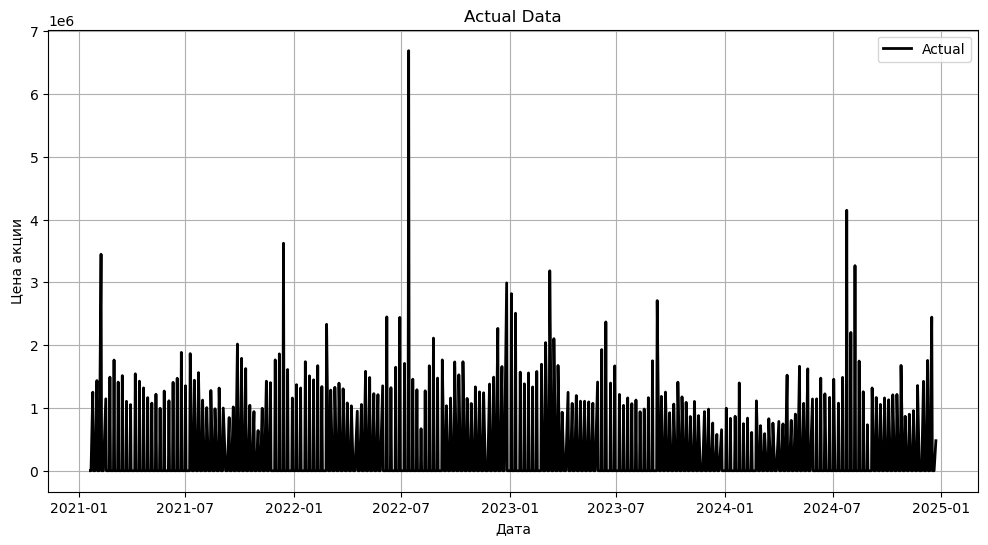

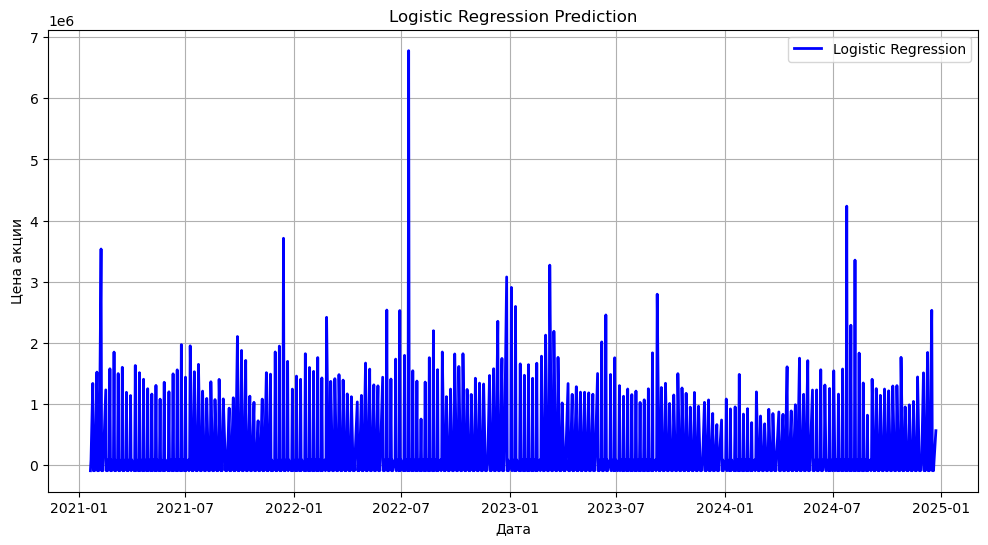

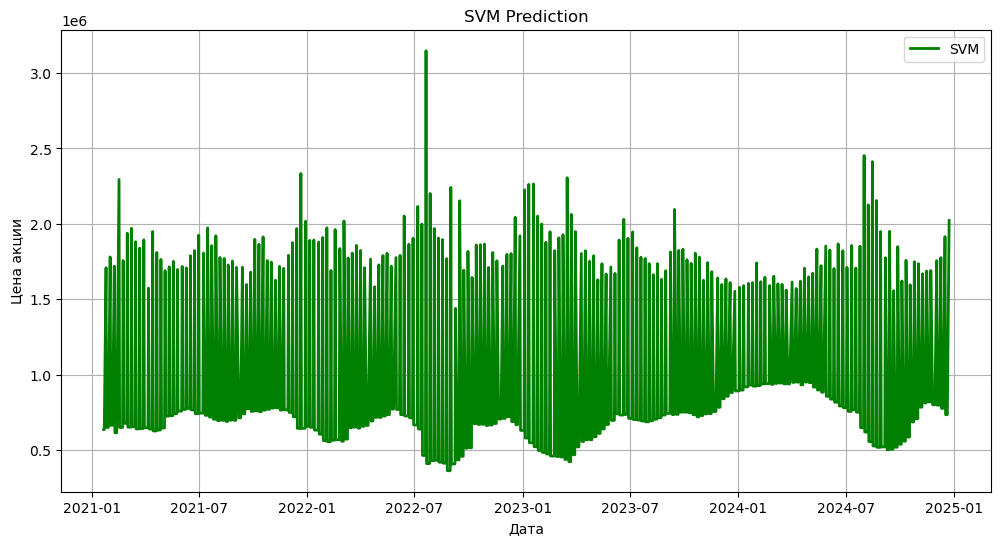

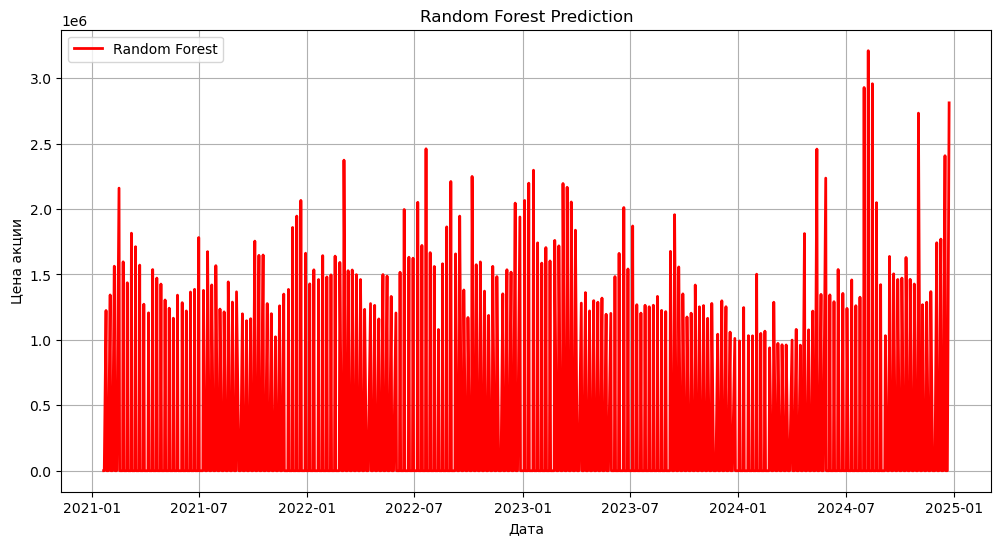

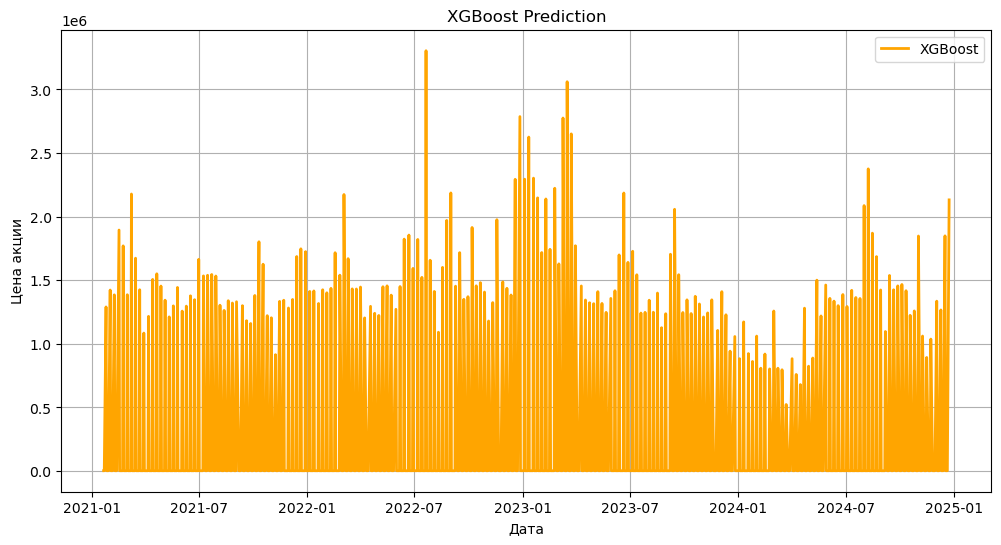

In [84]:
# Реальные данные (по времени)
plt.figure(figsize=(12, 6))
plt.plot(data_filtered.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual', color='black', linewidth=2)
plt.title('Actual Data')
plt.xlabel('Дата')
plt.ylabel('Цена акции')
plt.legend()
plt.grid(True)
plt.show()

# Логистическая регрессия (по времени)
plt.figure(figsize=(12, 6))
plt.plot(data_filtered.index[-len(y_test):], scaler.inverse_transform(lr_pred.reshape(-1, 1)), label='Logistic Regression', color='blue', linewidth=2)
plt.title('Logistic Regression Prediction')
plt.xlabel('Дата')
plt.ylabel('Цена акции')
plt.legend()
plt.grid(True)
plt.show()

# SVM (по времени)
plt.figure(figsize=(12, 6))
plt.plot(data_filtered.index[-len(y_test):], scaler.inverse_transform(svm_pred.reshape(-1, 1)), label='SVM', color='green', linewidth=2)
plt.title('SVM Prediction')
plt.xlabel('Дата')
plt.ylabel('Цена акции')
plt.legend()
plt.grid(True)
plt.show()

# Random Forest (по времени)
plt.figure(figsize=(12, 6))
plt.plot(data_filtered.index[-len(y_test):], scaler.inverse_transform(rf_pred.reshape(-1, 1)), label='Random Forest', color='red', linewidth=2)
plt.title('Random Forest Prediction')
plt.xlabel('Дата')
plt.ylabel('Цена акции')
plt.legend()
plt.grid(True)
plt.show()

# XGBoost (по времени)
plt.figure(figsize=(12, 6))
plt.plot(data_filtered.index[-len(y_test):], scaler.inverse_transform(xgb_pred.reshape(-1, 1)), label='XGBoost', color='orange', linewidth=2)
plt.title('XGBoost Prediction')
plt.xlabel('Дата')
plt.ylabel('Цена акции')
plt.legend()
plt.grid(True)
plt.show()
